## MODEL USING HISTOGRAM


In [3]:
import os
import time
import numpy as np
import io
import cv2
import pandas as pd
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import load_img, img_to_array

In [4]:
def extract_b_channel_features(image, bins=50):
    lab_image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2LAB)
    b_channel = lab_image[:, :, 2]

    b_channel = (b_channel - b_channel.min()) / (b_channel.max() - b_channel.min())
    b_hist = np.histogram(b_channel, bins=bins, range=(0, 1), density=True)[0]

    return b_hist

def load_images_and_labels(folder, label, bins=10):
    images = []
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        image = tf.keras.utils.img_to_array(tf.keras.utils.load_img(image_path))
        color_features = extract_b_channel_features(image, bins)
        images.append(color_features.reshape(1, -1))
    labels = [label] * len(images)
    return np.vstack(images), np.array(labels)

# Load dataset
train_jaundiced_images, train_jaundiced_labels = load_images_and_labels(
    "./new/Jaundiced Class/train", 1
    )
train_healthy_images, train_healthy_labels = load_images_and_labels(
    "./new/Normal Class/train", 0
    )

X_train = np.vstack((train_jaundiced_images, train_healthy_images))
y_train = np.hstack((train_jaundiced_labels, train_healthy_labels))

X_train, y_train = shuffle(X_train, y_train, random_state=1)

test_jaundiced_images, test_jaundiced_labels = load_images_and_labels(
    "./new/Jaundiced Class/test", 1
    )
test_healthy_images, test_healthy_labels = load_images_and_labels(
    "./new/Normal Class/test", 0
    )

X_test = np.vstack((test_jaundiced_images, test_healthy_images))
y_test = np.hstack((test_jaundiced_labels, test_healthy_labels))

val_jaundiced_images, val_jaundiced_labels = load_images_and_labels(
    "./new/Jaundiced Class/validate", 1
    #"./validate/validate J", 1
    )
val_healthy_images, val_healthy_labels = load_images_and_labels(
    "./new/Normal Class/validate", 0
    )

X_val = np.vstack((val_jaundiced_images, val_healthy_images))
y_val = np.hstack((val_jaundiced_labels, val_healthy_labels))

# Print dataset details for debugging
print("Test data shape:", X_test.shape)
print("Validation data shape:", X_val.shape)
print("Jaundiced images shape:", train_jaundiced_images.shape)
print("Healthy images shape:", train_healthy_images.shape)
print("X_train shape:", X_train.shape)
print("X_train dtype:", X_train.dtype)
print("First 5 rows of X_train:", X_train[:5])


Test data shape: (241, 10)
Validation data shape: (245, 10)
Jaundiced images shape: (334, 10)
Healthy images shape: (392, 10)
X_train shape: (726, 10)
X_train dtype: float64
First 5 rows of X_train: [[0.0725  0.28525 0.49775 0.71375 1.2575  4.025   2.5815  0.2935  0.2185
  0.05475]
 [0.02575 0.1095  0.3765  0.311   0.569   1.20725 2.85975 3.328   1.20325
  0.01   ]
 [0.107   0.095   0.254   1.45    4.127   3.199   0.424   0.193   0.099
  0.052  ]
 [0.037   0.102   0.13    0.189   0.814   1.488   2.325   2.762   1.652
  0.501  ]
 [0.175   0.359   0.6     0.63    1.227   2.635   2.794   1.161   0.379
  0.04   ]]


In [5]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)

X_train shape: (726, 10)
X_test shape: (241, 10)
X_val shape: (245, 10)


In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit 
X_test = scaler.transform(X_test)       # Transform test data (images only with no annotations but with features)
X_val = scaler.transform(X_val)

In [7]:
model = Sequential([
    Dense(512, kernel_regularizer=l2(0.01), input_dim=X_train.shape[1]),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(256, kernel_regularizer=l2(0.01)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, kernel_regularizer=l2(0.005)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, kernel_regularizer=l2(0.005)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.1),

    Dense(1, activation='sigmoid')  # Binary classification
])

C:\Users\kenji\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\kenji\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [10]:
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Callbacks Early Stopping and Reduce LR on Plateau
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=7, restore_best_weights=True)  
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

#Training
start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

elapsed_time = time.time() - start_time

# Evaluate Model
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
stopped_epoch = early_stopping.stopped_epoch

print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Test Precision: {precision:.4f}, Test Recall: {recall:.4f}")
print(f"Training stopped at Epoch: {stopped_epoch}, Time Taken: {elapsed_time:.2f} sec")


Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8726 - loss: 0.4827 - precision_2: 0.8477 - recall_2: 0.8636 - val_accuracy: 0.8857 - val_loss: 0.4102 - val_precision_2: 0.8696 - val_recall_2: 0.8850 - learning_rate: 5.0000e-04
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8741 - loss: 0.4747 - precision_2: 0.8523 - recall_2: 0.8595 - val_accuracy: 0.8857 - val_loss: 0.4495 - val_precision_2: 0.9208 - val_recall_2: 0.8230 - learning_rate: 5.0000e-04
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9021 - loss: 0.4030 - precision_2: 0.9039 - recall_2: 0.8905 - val_accuracy: 0.8490 - val_loss: 0.4817 - val_precision_2: 0.8654 - val_recall_2: 0.7965 - learning_rate: 5.0000e-04
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8826 - loss: 0.4262 - precision_2: 0.8829 - recall_2: 0.8609 - val_accuracy: 0.8816 - val_loss: 0.4466 - val_precision_2: 0.9286 - val_recall_2: 0.8053 - learning_rate: 5.0000e-04
Epoch 5/50
46/46 ━━━━━━

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001853134FD80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        65
           1       1.00      1.00      1.00        55

    accu

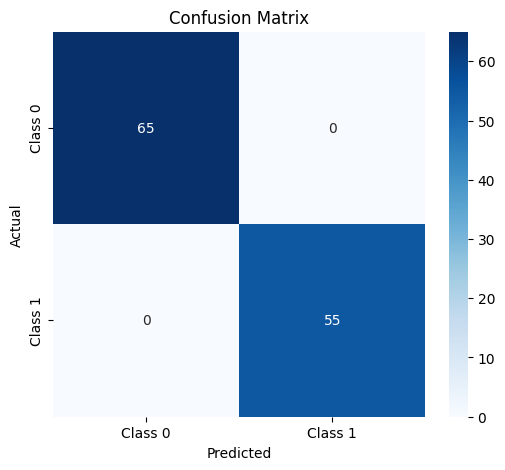

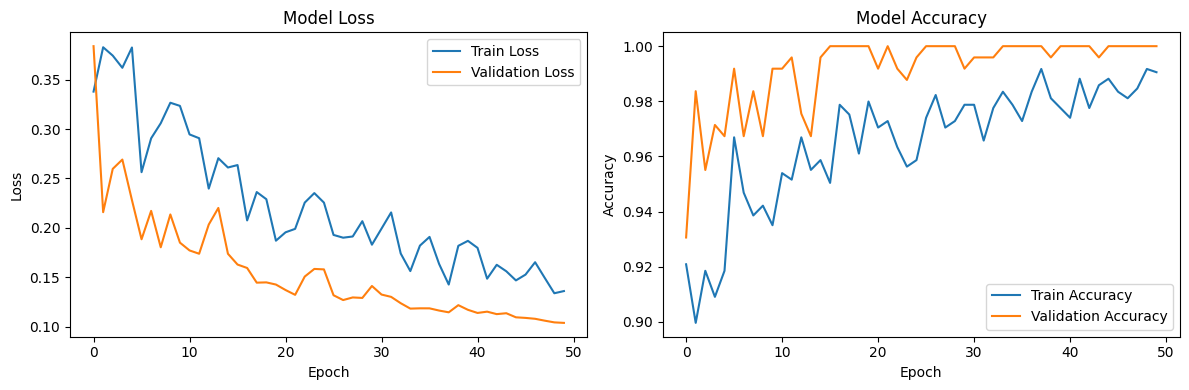

In [16]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(12, 4))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
